# Example: CitiBike data

Adapted from Kelsey Jordahl
https://gist.github.com/kjordahl/5957573

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import requests
import json
from pyproj import Proj
from shapely.geometry import Point
import geopandas as gp
from geopandas import GeoDataFrame
from scipy import ndimage


NYC borough boundaries downloaded from [Bytes of the Big Apple](http://www.nyc.gov/html/dcp/download/bytes/nybb_13a.zip)

In [2]:
boros = gp.GeoDataFrame.from_file('nybb_15b/nybb.shp')
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330466.075042,1.623827e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,3,Brooklyn,741185.900596,1.937597e+09,(POLYGON ((1021176.479003906 151374.7969970703...
2,4,Queens,897040.298576,3.045168e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,1,Manhattan,358408.460709,6.364467e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464400.198868,1.186973e+09,(POLYGON ((1012821.805786133 229228.2645874023...


Load real time bike station data from [CitiBike](http://citibikenyc.com) json API:

In [3]:
# get the bike data and convert it to a ditcionary
endpoint_url = 'http://citibikenyc.com/stations/json'
response = requests.get(endpoint_url)
data = json.loads(response.text)

In [4]:
# convert the relevant part to a geodataframe
df = GeoDataFrame(data['stationBeanList'])
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,34,1,,72,,2018-04-22 08:38:22 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,7,25,,79,,2018-04-22 08:37:58 AM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,27,0,,82,,2018-04-22 08:37:06 AM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
3,,36,24,,83,,2018-04-22 08:37:43 AM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,6,13,,119,,2018-04-22 08:40:03 AM,40.696089,,-73.978034,,Park Ave & St Edwards St,,Park Ave & St Edwards St,1,In Service,False,19


In [5]:
# there is one row for each bike station.  How many stations are there? 
len(df)

812

In [6]:
# in the file above, there are lon-lats, but no geometry field
# we need to set that up

s = gp.GeoSeries([Point(x, y) for x, y in zip(df['longitude'], df['latitude'])])
df['geometry'] = s
df.crs = {'init': 'epsg:4326', 'no_defs': True}
df.geometry.total_bounds

array([-74.0887723 ,  40.65539977, -73.9077436 ,  40.81439444])

In [7]:
# make sure they are on the same CRS.  
# checking the bounds is a nice way of seeing this
df.to_crs(boros.crs, inplace=True)
df.geometry.total_bounds

array([ 959640.46484504,  178056.37414829, 1009803.53178432,
        235986.42166716])

In [8]:
# the geometry objects can do lots of cool stuff.  For example: 

manhattan = boros.geometry[3]
in_mn = df.geometry.within(manhattan)
print(sum(in_mn), 'stations in Manhattan')

412 stations in Manhattan


In [9]:
10000-sum(df['availableBikes'])

-231

# Your turn

You can read about the range of operations available in geopandas here: 
    
http://geopandas.org/index.html

Your assignment is to: 

1. Calculate how many stations are in each borough
2. Calculate how many bikes are currently available in each borough
3. Read about and try at least two new spatial or geometric operations (beyond what I've covered here). 

In [10]:
#set up each boro
staten_island = boros.geometry[0]
brooklyn = boros.geometry[1]
queens = boros.geometry[2]
manhattan = boros.geometry[3]
bronx = boros.geometry[4]

In [11]:
in_si = df.geometry.within(staten_island)
in_b = df.geometry.within(brooklyn)
in_q = df.geometry.within(queens)
in_mn = df.geometry.within(manhattan)
in_bx = df.geometry.within(bronx)

print(sum(in_si), 'stations in Staten Island')
print(sum(in_b), 'stations in Brooklyn')
print(sum(in_q), 'stations in Queens')
print(sum(in_mn), 'stations in Manhattan')
print(sum(in_bx), 'stations in Bronx')

0 stations in Staten Island
267 stations in Brooklyn
81 stations in Queens
412 stations in Manhattan
0 stations in Bronx


In [12]:
#write function to sum available bikes in boro given input of boro geometry
def sumAvailableBikes(boro):
    total = 0
    i = 0
    while (i < len(df)):
        if(df['geometry'][i].within(boro)==True):
            total = total + df['availableBikes'][i]
        i = i+1
    return(total)

In [13]:
print(sumAvailableBikes(staten_island), 'available bikes in Staten Island')
print(sumAvailableBikes(brooklyn), 'available bikes in Brooklyn')
print(sumAvailableBikes(queens), 'available bikes in Queens')
print(sumAvailableBikes(manhattan), 'available bikes in Manhattan')
print(sumAvailableBikes(bronx), 'available bikes in Bronx')

0 available bikes in Staten Island
3518 available bikes in Brooklyn
713 available bikes in Queens
5621 available bikes in Manhattan
0 available bikes in Bronx


C:\Users\Michael\Anaconda3\lib\site-packages\geopandas\plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


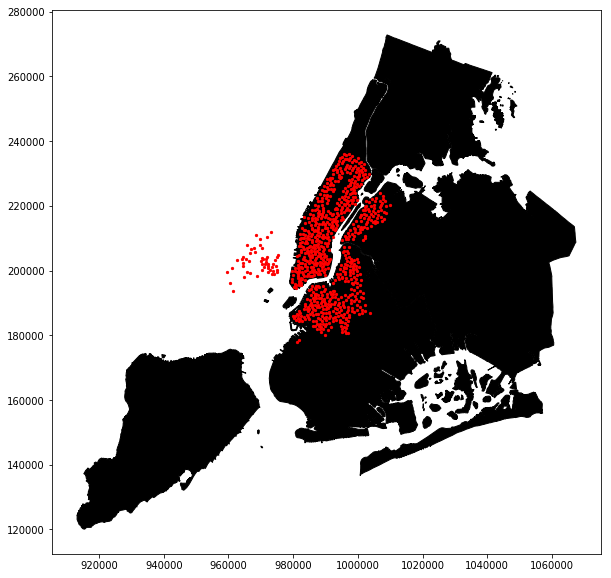

In [14]:
base = boros.plot(column = 'Shape_Area',figsize = (10,10), color = 'black', edgecolor = 'black')
df.plot(ax = base, marker='o', color='red', markersize = 5)

In [15]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


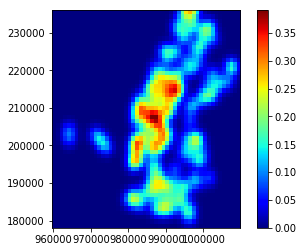

In [16]:
heatmap(df['geometry'], bins=50, smoothing=1.3)